## TP2 : Programmation dynamique et apprentissage par renforcement tabulaire
- Nom    : GHOUL,  ALLIOUI
- Prenom : Branis, Lounes

**Contenu du rendu** :

- L'algorithme contenait une étude du nombre d'appels à la fonction `evaluate_one_step()` avant la convergence de `generalized_policy_iteration()` pour différentes valeurs de $k$, où $k$ est le nombre d'étapes d'évaluation que nous prenons avant chaque étape d'amélioration de la politique.
- La fonction `get_policy_from_q()`.
- La fonction `sarsa_soft()`, et tout le code nécessaire pour exécuter l'algorithme `generalized_policy_iteration()`.

In [ ]:
# Import all the tools we need
import os
from typing import Tuple, List
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from my_gym.envs.maze_mdp import MazeMDPEnv
from mazemdp import random_policy
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gym
import my_gym

# Settings
NB_EPISODES = 50
TIMEOUT = 25

In [ ]:
# Création de l'environnement MazeMDP
env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()

### 1- La function `get_policy_from_q()` 
Il prend comme paramètres la `q_table` et retourne la politique optimale pour chaque état.

In [ ]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    return np.argmax(q, axis=1)

### 2- La function `sarsa_soft()`

In [ ]:
# --------------------------- Sarsa, softmax version -------------------------------#

# Given a temperature "tau", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def sarsa_soft(
    mdp: MazeMDPEnv,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = False

        ## =============== To be completed... ==================== ##  
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an softmax policy
            u  = discreteProb(softmax(q, x, tau))       # Utlisation de discreteProb
            if u == -1:
              u = np.random.choice(np.where(softmax(q, x, tau) == softmax(q, x, tau).max())[0])
            # Perform a step of the MDP
            [y, r, done, _] = mdp.step(u)
            u_prim = np.argmax(q[y, :]) # Action suivante
        ## ================================================== ##
            
            ## =============== To be completed... ==================== ##          
            delta = r + mdp.gamma * q[y, u_prim] - q[x, u]
            q[x, u] = q[x, u] + alpha*delta

            x = y
            u = u_prim
         ## ================================================== ##

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Sarsa softmax")
    return q, q_list


#### 2.1 Exécution de l'algorithme `sarsa_soft()`

In [ ]:
tau = 6
q, q_list = sarsa_soft(env, tau, nb_episodes = NB_EPISODES)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

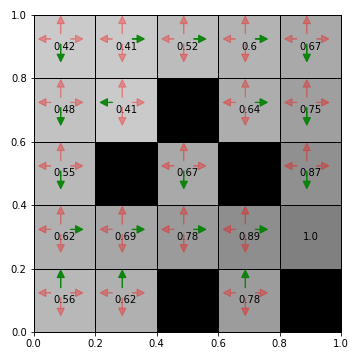

#### **Fonctionnement du code :**

**a. Difficulté :**
- La difficulté dans cette  partie réside dans la fonction `solftmax()`, cette dernière nous renvoie une distribution de probabilités 
dans un tableau `nd.array`  contenant les probabilités de chaque actions **Droite, gauche, Haut, Bas** pour un état donné. 

**b. Hypotheses :**
- La première intuition  dans ce cas, est de prendre à chaque fois la meilleure action, soit le `np.argmax(solftmax())`. Or, dans notre algorithme 
`sarsa_soft()` nous avons initialisé dès le départ notre `q_table` à zero. Par conséquent, les probabilités renvoyées par la fonction 
`softmax()` sont égaux pour chaque état sauf l'état final (si nous avons de la chance lors de mise à jour aléatoires de l'état de 
départ d'un épisode), 
l'action renvoyé par `np.argmax(solftmax())` reste inchangé (action 0 par défaut). 
La raison est  que notre algorithme n'a pas encore 
exploré l'environnement, autrement dit notre algorithme n'as pas encore estimé suffisamment de probabilités des actions pour les états 
de la `q_table`. 

**c. Solution :**

La solution de cette problématique, est d'utiliser la fonction `discreteProb()`, qui permet de tirer une action aléatoire 
sur une distribution de probabilité tout en utilisant une stratégie pour résoudre le dilemme du compromis exploration et exploitation.

#### **Remarque :**
- Malgré  que la fonction `sarsa_soft()` donne de meilleurs résultats par rapport au `sarsa_eps(), q_learning_soft(), q_learning_eps() `(fait en TP2), mais elle est très gourmande en terme de temps de calcule.

- Contrairement à `q_learning`, `sarsa` a besoin de connaître l'action suivante afin de calculer la nouvelle `q_table`.

### 3- La fonction `generalized_policy_iteration()`.
#### 1- Code nécessaire pour exécuter l'algorithme

Voici les fonctions `evaluate_one_step_q()` et `evaluate_q()` nécessaires pour exécuter l'algorithme `generalized_policy_iteration()`.

In [ ]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    # À compléter...  
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                # À compléter...  
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
    return qnew


In [ ]:
def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray, jusqu_a_convergence, K) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    k = 0
    if jusqu_a_convergence == True :
      while not stop:
          k+= 1
          qold = q.copy()
          q = evaluate_one_step_q(mdp, qold, policy)
          # Test if convergence has been reached
          if (np.linalg.norm(q - qold)) < 0.01:
              stop = True
    else :
      for k in range(K):
          qold = q.copy()
          q = evaluate_one_step_q(mdp, qold, policy)
    return q,k

#### 2- La fonction `generalized_policy_iteration()`.

In [ ]:
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def generalized_policy_iteration_q(mdp: MazeMDPEnv, render: bool = True, K: int=8, jusqu_a_convergence = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    k_list = []
    policy = random_policy(mdp)

    stop = False
    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q, k = evaluate_q(mdp, policy, jusqu_a_convergence, K)
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q) 

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        k_list.append(k)
    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list, k_list


In [ ]:
def plot_graph(q_list,k_list):
  plt.plot(q_list, label='Generalized_policy_iteration',color = 'b')
  plt.legend()
  plt.plot(k_list, label="Nombre d'itérations",color = 'g')
  plt.legend()

  plt.xlabel('Number of episodes')
  #plt.ylabel()
  plt.title('value of K and Q')
  plt.show()

  print("Le nombre total d'iteration est : ", np.sum(k_list),"iterations")

#### 3- Application de `generalized_policy_iteration()`
a. Dans cette partie nous allons exécuter la fonction `generalized_policy_iteration()` jusqu'à convergence, puis estimer le nombre d'itérations $K$ 

Output()

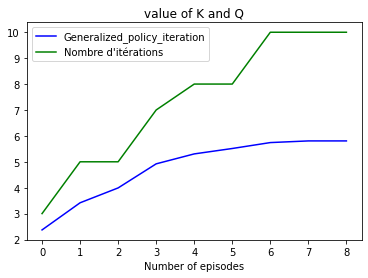

Le nombre total d'iteration est :  66 iterations


In [ ]:
q, q_list,k_list = generalized_policy_iteration_q(env, render=True, jusqu_a_convergence=True)
plot_graph(q_list,k_list)

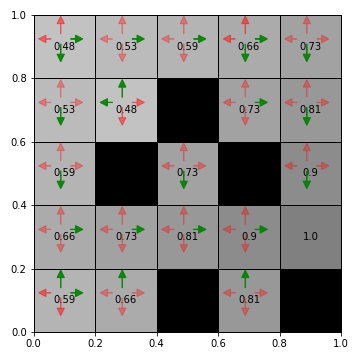

**Interprétation:**
- Cette courbe verte représente le nombre de fois que la fonction `evaluate_one_step_q()` est appelée à chaque convergence de la fonction `evaluate_q()`.

**Note:**
- À chaque convergence de la fonction `evaluate_q()`, la valeur de $K$ augmente.
- La valeur de $K$ est inversement proportionnelle à l'erreur `(np.linalg.norm(q - qold))`. (Plus l'erreur est petite, plus la valeur de K augmente pour atteindre la convergence).

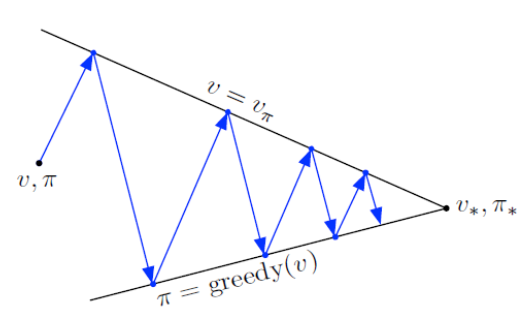

**Pour minimiser le nombre d'appels de la fonction `evaluate_one_step_q()`, la solution est de trouver un K optimal sans atteindre la convergence de la fonction `evaluate_q()`**.

b. Cette fois, nous appliquons la fonction `generalized_policy_iteration()` avec un nombre d'itération $K$ variable de 7 à 10

In [ ]:
for K in range(7,11):
  print("\n-------- Avec K =", K, "iterations ----------")
  q, q_list,k_list = generalized_policy_iteration_q(env, render=False, jusqu_a_convergence=False, K = K)
  print("Le nombre total d'iteration est : ", np.sum(k_list),"iterations")


-------- Avec K = 7 iterations ----------
Le nombre total d'iteration est :  42 iterations

-------- Avec K = 8 iterations ----------
Le nombre total d'iteration est :  56 iterations

-------- Avec K = 9 iterations ----------
Le nombre total d'iteration est :  64 iterations

-------- Avec K = 10 iterations ----------
Le nombre total d'iteration est :  72 iterations


**Note:**

- Pour rappel l'algorithme a mis $66$ itérations pour converger.
- Pour la valeur de $k=10$, l'algorithme est plus long.
- On remarque que pour les valeurs de $k = 7,8,9$ on prend moins de temps de calcul.
- La question est maintenant de savoir quelle est la valeur optimale de $k$ (bons résultats et moins de temps de calcul) ?

#### Avec la valeur de K = 7

In [ ]:
q, q_list,k_list = generalized_policy_iteration_q(env, render=True, jusqu_a_convergence=False, K = 7)

Output()

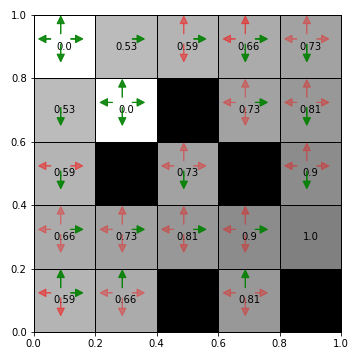

#### Avec la valeur de K = 8

In [ ]:
q, q_list,k_list = generalized_policy_iteration_q(env, render=True, jusqu_a_convergence=False, K = 8)

Output()

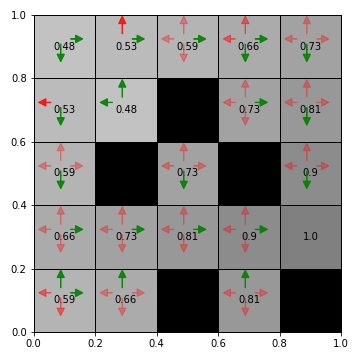

**Interprétation:**
- $k = 7$, l'algorithme n'explore jamais tous les états de l'envirement.
- $k = 8$ présente un résultat similaire au cas de l'utilisation d'une boucle jusqu'à convergence avec un nombre total d'itérations de $56 < 66$.
- Nous pouvons donc en déduire que la meilleure valeur est $K = 8$.
- Nous avons gagné 10 itérations ce qui rend le programme plus rapide.

**Note:**
- Il est très intéressant d'estimer la valeur optimale du nombre d'appels à la fonction `evaluate_one_step_q()` car pour des applications LR importantes, même quelques itérations peuvent faire une grande différence en terme de temps de calcul.

- La principale différence entre les méthodes classiques de programmation dynamique et les algorithmes d'apprentissage par renforcement est que ces derniers ne supposent pas la connaissance d'un modèle mathématique exact du MDP et qu'ils visent les MDP de grande taille pour lesquels les méthodes exactes deviennent infaisables.